# Bookings

O objetivo desse relatório é criar e avaliar um modelo SARIMA a partir de uma base de dados de reservas de um hotel.

Para isso, o relatório é dividido em 3 tópicos:

1) Preparação da base de dados
2) Modelagem
3) Avaliação do modelo

# 1) Preparação da base de dados

Como a base de dados possui um componente sazonal, foi necessário realizar uma diferenciação sazonal e uma primeira diferenciação para tornar a base estacionária e realizar a modelagem dos dados. O primeiro tópico mostra esse processo de preparação da base para rodar os modelos.

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [3]:
df = pd.read_excel('bookings.xlsx')
df.head()

,Year,Month,Bookings
0,2006,Jan,383
1,2006,Feb,366
2,2006,Mar,250
3,2006,Apr,318
4,2006,May,334


<AxesSubplot:xlabel='Month'>

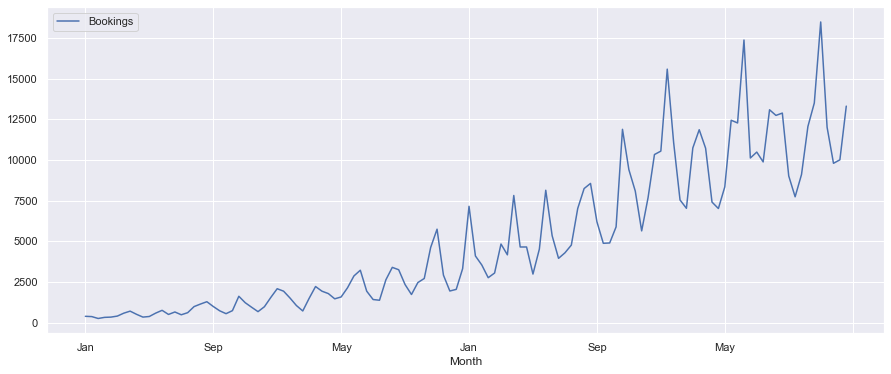

In [4]:
sns.set(rc={'figure.figsize':(15, 6)})
df.plot(x='Month', y='Bookings')

In [5]:
df['Seasonal Difference'] = df['Bookings'].diff(periods=12)
df.head()

,Year,Month,Bookings,Seasonal Difference
0,2006,Jan,383,NaN
1,2006,Feb,366,NaN
2,2006,Mar,250,NaN
3,2006,Apr,318,NaN
4,2006,May,334,NaN


In [7]:
df['Seasonal Difference'] = df['Seasonal Difference'].fillna(0)
df.index = df['Year'].astype(str) + '_' + df['Month']
df = df.drop(['Year', 'Month'], axis=1)
df.head()

,Bookings,Seasonal Difference,1D
2006_Jan,383,0.0,0.0
2006_Feb,366,0.0,0.0
2006_Mar,250,0.0,0.0
2006_Apr,318,0.0,0.0
2006_May,334,0.0,0.0


In [8]:
# como o p-valor é maior que 0.05, é necessário fazer uma primeira diferenciação
ad_fuller_result = adfuller(df['Seasonal Difference'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -2.793935116601018
p-value: 0.059145329493272336


In [6]:
df['1D'] = df['Seasonal Difference'].diff()
df['1D'] = df['1D'].fillna(0)
df.head()

,Year,Month,Bookings,Seasonal Difference,1D
0,2006,Jan,383,NaN,0.0
1,2006,Feb,366,NaN,0.0
2,2006,Mar,250,NaN,0.0
3,2006,Apr,318,NaN,0.0
4,2006,May,334,NaN,0.0


In [9]:
# O p-valor menor que 0.05 mostra que série temporal é estacionária
ad_fuller_result = adfuller(df['1D'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -4.239517306498945
p-value: 0.000564443264706689


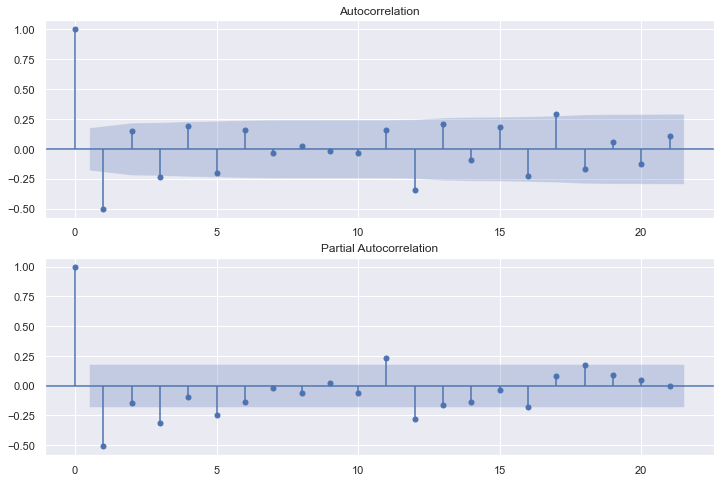

In [10]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['1D'].values.squeeze(), ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['1D'], ax=ax2)

# 2) Modelagem

Para criar o modelo SARIMA, selecionei os seguintes critérios:

Como o gráfico acima mostra um lag-1 positivo e com os dois primeiros lags significativos, selecionei um modelo autoregressivo com p=2 e P=1. Como geralmente modelos autoregressivos não possuem componente de média móvel, q=0 e Q=0. A série sofreu duas diferenciações: a diferenciação sazonal e a primeira diferenciação. Por isso, d=1 e D=1. Por fim, a sazonalidade do modelo é mensal, levando a m=12.

Portanto, tem-se: ARIMA(p, d, q)(P, D, Q)m -> ARIMA(2, 1, 0)(1, 1, 0)12

Também rodei os parâmetros de modelo SARIMA sugerido pelo curso, que mostrou ter melhores índices de AIC, portanto, foi um modelo de maior acurácia.

In [14]:
# Modelo 1

mod1 = SARIMAX(df['1D'], order=(2, 1, 0), seasonal_order=(1, 1, 0, 12))
res1 = mod1.fit()
print(res1.summary())

C:\Users\Victoria\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\Victoria\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


                                     SARIMAX Results                                      
Dep. Variable:                                 1D   No. Observations:                  120
Model:             SARIMAX(2, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -949.914
Date:                            Sat, 23 Oct 2021   AIC                           1907.827
Time:                                    21:26:59   BIC                           1918.519
Sample:                                         0   HQIC                          1912.161
                                            - 120                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0309      0.072    -14.347      0.000      -1.172      -0.890
ar.L2         -0.3944      0.071   

In [15]:
# Modelo 2

mod2 = SARIMAX(df['1D'], order=(0, 1, 1), seasonal_order=(0, 1, 1, 12))
res2 = mod2.fit()
print(res2.summary())

C:\Users\Victoria\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\Victoria\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\Victoria\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Victoria\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


                                     SARIMAX Results                                      
Dep. Variable:                                 1D   No. Observations:                  120
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -936.579
Date:                            Sat, 23 Oct 2021   AIC                           1879.158
Time:                                    21:27:08   BIC                           1887.177
Sample:                                         0   HQIC                          1882.409
                                            - 120                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0000     14.709     -0.068      0.946     -29.828      27.828
ma.S.L12      -0.9982     14.712   

# 3) Avaliação do modelo

A avaliação de ambos os modelos permitem selecionar o melhor deles. Os índices de AIC mostram que provavelmente o segundo modelo rodado é o mais adequado para a série temporal.

Os dois modelos mostraram um índice de autocorrelação maior que um desvio padrão, portanto, provavelmente os parâmetros poderiam ser ajustados para criar um modelo melhor. Porém, entre os dois modelos, o segundo parece ser melhor por ter menores índices de AIC.

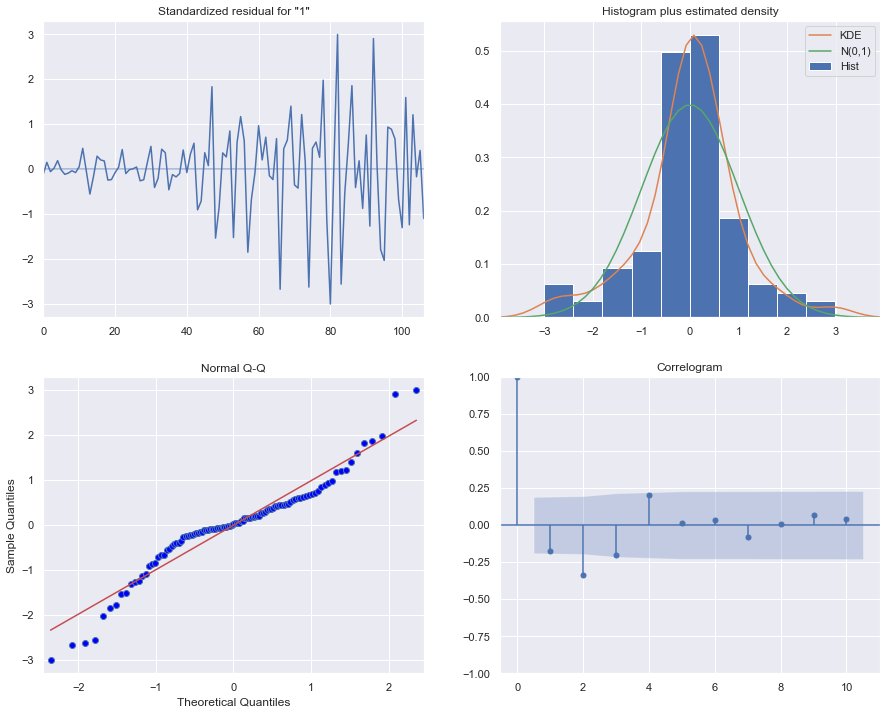

In [16]:
res1.plot_diagnostics(figsize=(15, 12))
plt.show()

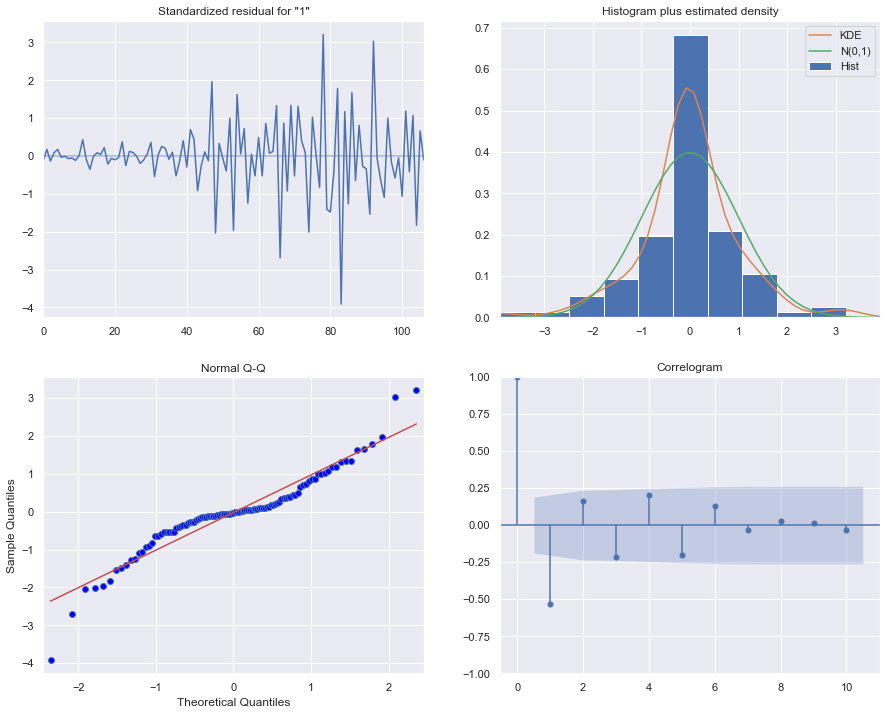

In [17]:
res2.plot_diagnostics(figsize=(15, 12))
plt.show()